In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, box
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import seaborn as sns; sns.set(style="darkgrid")
%matplotlib inline

In [2]:
# convert list to str with '/' between the letters
def list_str(my_list):    
    my_str = my_list[0]
    for i in my_list[1:]:
        my_str = my_str+ '/' + i
    return (my_str)

In [3]:
# # Calculate the number of layers using the name of the polygon
def elements_in_list(the_list):
    w = the_list.split("/")
    my_list = list(set(w))
    list_len = len(my_list)
    my_list.sort()
    return (list_len, my_list)

In [4]:
def annotate_polygon(gdf, geom_col, col):
    '''
    visualization of overlapping poligons
    Contains annotation describing the names of the overlapping polygons or the number of overlapping polygons
    Parameters
    ----------
    gdf : geodatafreame
        The geodatafreame Should include the following fields:
        geometry - the polygon
        name - The name of the polygon
        #polygons - The number of polygons that make up the polygon 
    geom_col : str
        the name of the polygon columen 
    col : str
        the name of the columen for annotate
        Ex: 'name' or '#polygons'
    '''
    gdf['centroid'] = gdf[geom_col].centroid
    gdf['N_centroid'] = gdf['centroid'].apply(coords)
    gdf.plot(alpha=0.5, figsize=(18,20), edgecolor='black')
    for idx, row in gdf.iterrows():
        plt.annotate(text=row[col], xy=row['N_centroid'], horizontalalignment='center');

In [5]:
# calculating the name = the polygons that are overlapping
def num_polygon(name_1, name_2):
    if name_1 == name_2:
        name = name_1
    else: 
        name = name_1 + '/' + name_2 
    name_str = list_str(elements_in_list(name)[1])
    return (name_str)

In [6]:
def new_features (df):
    df['name'] = df.apply(lambda x: num_polygon(x['name_1'], x['name_2']), axis=1) #Calculating the name
    df['#polygons'] = df.apply(lambda x: elements_in_list(x['name'])[0], axis=1) # Calculate the number of layers
    df['id'] = df.index
    return(df)

In [7]:
# To allow placement of the caption in the middle of the polygon
def coords(point):
    N_point = point.coords[:]
    N_point = N_point[0]
    return(N_point)

In [8]:
def one_iteration(df):
    global iteration_num
    iteration_num += 1
    #print ('num of iterations:', iteration_num)
    df = gpd.overlay(df, df, how='intersection') # Perform spatial overlay between two GeoDataFrames
    df = new_features(df) # new fetures for display 
    df.drop(['id', 'name_1', 'name_2', '#polygons_1', '#polygons_2'], axis=1, inplace=True)
    df.drop_duplicates(subset=['name'], inplace=True)
    return(df)

In [9]:
# For example: reducing 4 layers polygons from 3 layers polygons.
# Dividing the dataframe into three. The two layers that need to be reduced and all the rest.
# Then connecting everyone together
def geo_differenc(df, iteration_num):
    A = df.loc[df['#polygons'] == iteration_num]
    B = df.loc[df['#polygons'] == iteration_num +1]
    C = df.loc[~df['#polygons'].isin([iteration_num , iteration_num + 1])]
    AB = gpd.overlay(A, B, how='difference')
    df = pd.concat([AB, B, C])
    return(df)

In [177]:
# For example: reducing 4 layers polygons from 3 layers polygons.
# calculating the layers needed to reduce
def geo_differenc_itera(df):
    polygons_nam_max = df['#polygons'].max()
    #print ('max polygons:', polygons_nam_max)
    for i in range (iteration_num,polygons_nam_max):
        #print ('i:', i)
        df = geo_differenc(df, i)
    return(df)

In [178]:
data = {'name':  ['A', 'B', 'C'],
        'id': [1, 2, 3],
         'geometry': ['MULTIPOLYGON (((36.00000 11.00000, 36.00000 12.00000, 37.00000 12.00000, 37.00000 11.00000, 36.00000 11.00000)))', 'MULTIPOLYGON (((36.50000 11.50000, 37.50000 11.50000, 37.50000 11.00000, 36.50000 11.00000, 36.50000 11.50000)))', 'MULTIPOLYGON (((36.61799 10.80580, 36.61570 11.19321, 36.86327 11.29637, 37.34925 10.91813, 37.00540 10.71182, 36.61799 10.80580)))']
        }

df = pd.DataFrame (data, columns = ['name','id','geometry'])
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [179]:
# make some rectangles (for demonstration purposes and intersect with each other)
rect1 = box(32,10,37,13)
rect5 = box(32,10,37,13)
rect6 = box(32,10,37,13)
rect7 = box(32,10,37,13)
rect2 = box(32.5,11.5,35,15)
rect3 = box(33.5,12.5,36,17)
rect4 = box(33.5,10.5,37.2,12.3)

In [180]:
data2 = {'name':  ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
        'id': [4, 5, 6, 7, 8, 9, 10],
         'geometry': [rect1, rect2, rect3, rect4, rect5, rect6, rect7]
        }
df2 = pd.DataFrame (data2, columns = ['name','id','geometry'])
gdf2 = gpd.GeoDataFrame(df2, geometry='geometry')

In [181]:
gdf = gdf2.append(gdf)

In [182]:
gdf

,name,id,geometry
0,D,4,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
1,E,5,"POLYGON ((35.00000 11.50000, 35.00000 15.00000..."
2,F,6,"POLYGON ((36.00000 12.50000, 36.00000 17.00000..."
3,G,7,"POLYGON ((37.20000 10.50000, 37.20000 12.30000..."
4,H,8,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
5,I,9,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
6,J,10,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
0,A,1,"MULTIPOLYGON (((36.00000 11.00000, 36.00000 12..."
1,B,2,"MULTIPOLYGON (((36.50000 11.50000, 37.50000 11..."
2,C,3,"MULTIPOLYGON (((36.61799 10.80580, 36.61570 11..."


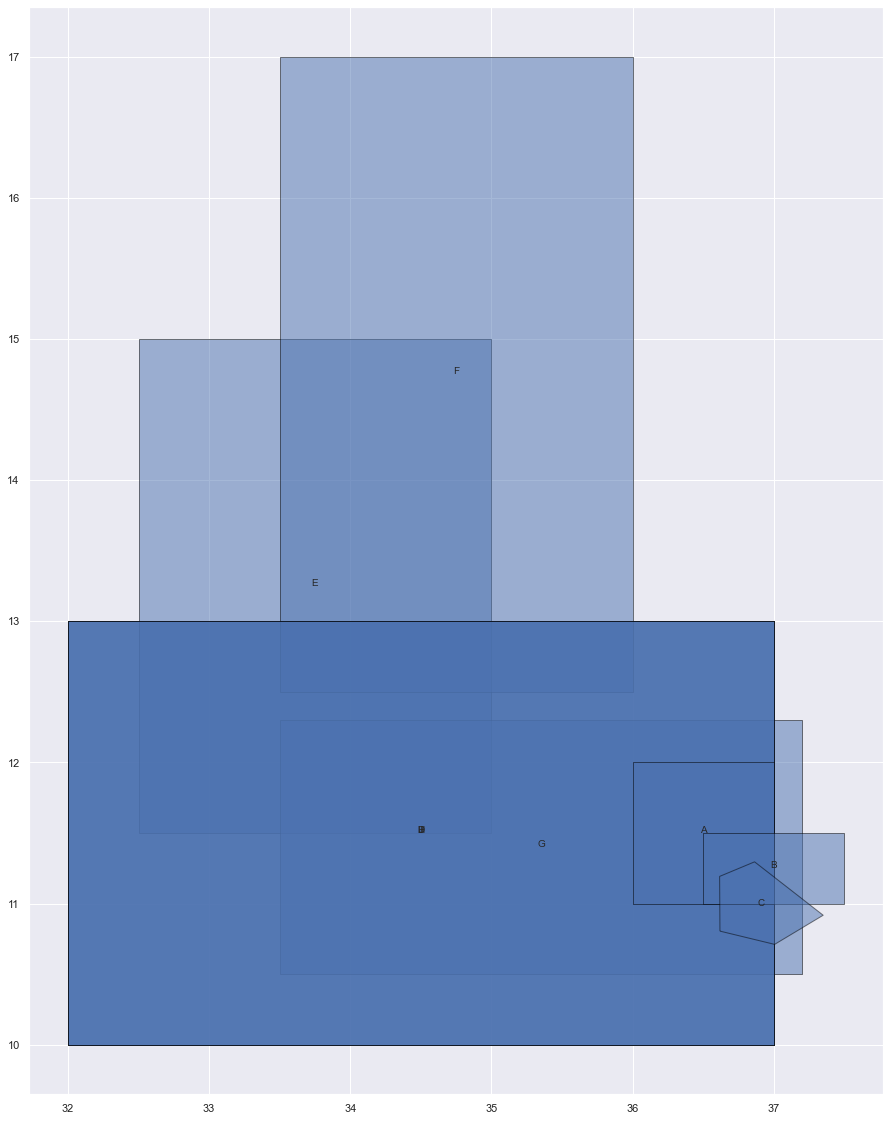

In [183]:
annotate_polygon(gdf, 'geometry', 'name')
gdf.drop(['id', 'N_centroid', 'centroid'], axis=1, inplace=True)

# start new

In [184]:
U_o = gdf

In [185]:
U = gpd.overlay(gdf, gdf, how='intersection')

In [186]:
U = new_features(U)
U.drop(['id', 'name_1', 'name_2'], axis=1, inplace=True)
U.drop_duplicates(subset=['name'], inplace=True)
iteration_num = 1
U = geo_differenc(U, 1)

In [187]:
U_o

,name,geometry
0,D,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
1,E,"POLYGON ((35.00000 11.50000, 35.00000 15.00000..."
2,F,"POLYGON ((36.00000 12.50000, 36.00000 17.00000..."
3,G,"POLYGON ((37.20000 10.50000, 37.20000 12.30000..."
4,H,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
5,I,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
6,J,"POLYGON ((37.00000 10.00000, 37.00000 13.00000..."
0,A,"MULTIPOLYGON (((36.00000 11.00000, 36.00000 12..."
1,B,"MULTIPOLYGON (((36.50000 11.50000, 37.50000 11..."
2,C,"MULTIPOLYGON (((36.61799 10.80580, 36.61570 11..."


In [188]:
while (not(U['name'].equals(U_o['name']))):
    U_o = U.copy()
    U = one_iteration(U)
    U = geo_differenc_itera(U)

In [189]:
# gdf - geodatafreame, geom_col - 
def visualization(gdf, geom_col, col):
    '''
    visualization of overlapping poligons as heatmap
    Parameters
    ----------
    gdf : geodatafreame
        The geodatafreame Should include the following fields:
        geometry - the polygon
        name - The name of the polygon
        #polygons - The number of polygons that make up the polygon 
    geom_col : str
        the name of the polygon column 
    col : str
        the name of the column for annotate
        Ex: 'name' or '#polygons'
    '''
    fig, ax = plt.subplots(1, figsize=(40, 20))
    color = 'Oranges'
    vmin, vmax = 0, gdf['#polygons'].max() 
    gdf['centroid'] = gdf[geom_col].centroid
    gdf['N_centroid'] = gdf['centroid'].apply(coords)
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=20)
    gdf.plot('#polygons', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
    for idx, row in gdf.iterrows():
        plt.annotate(text=row[col], xy=row['N_centroid'], horizontalalignment='center');

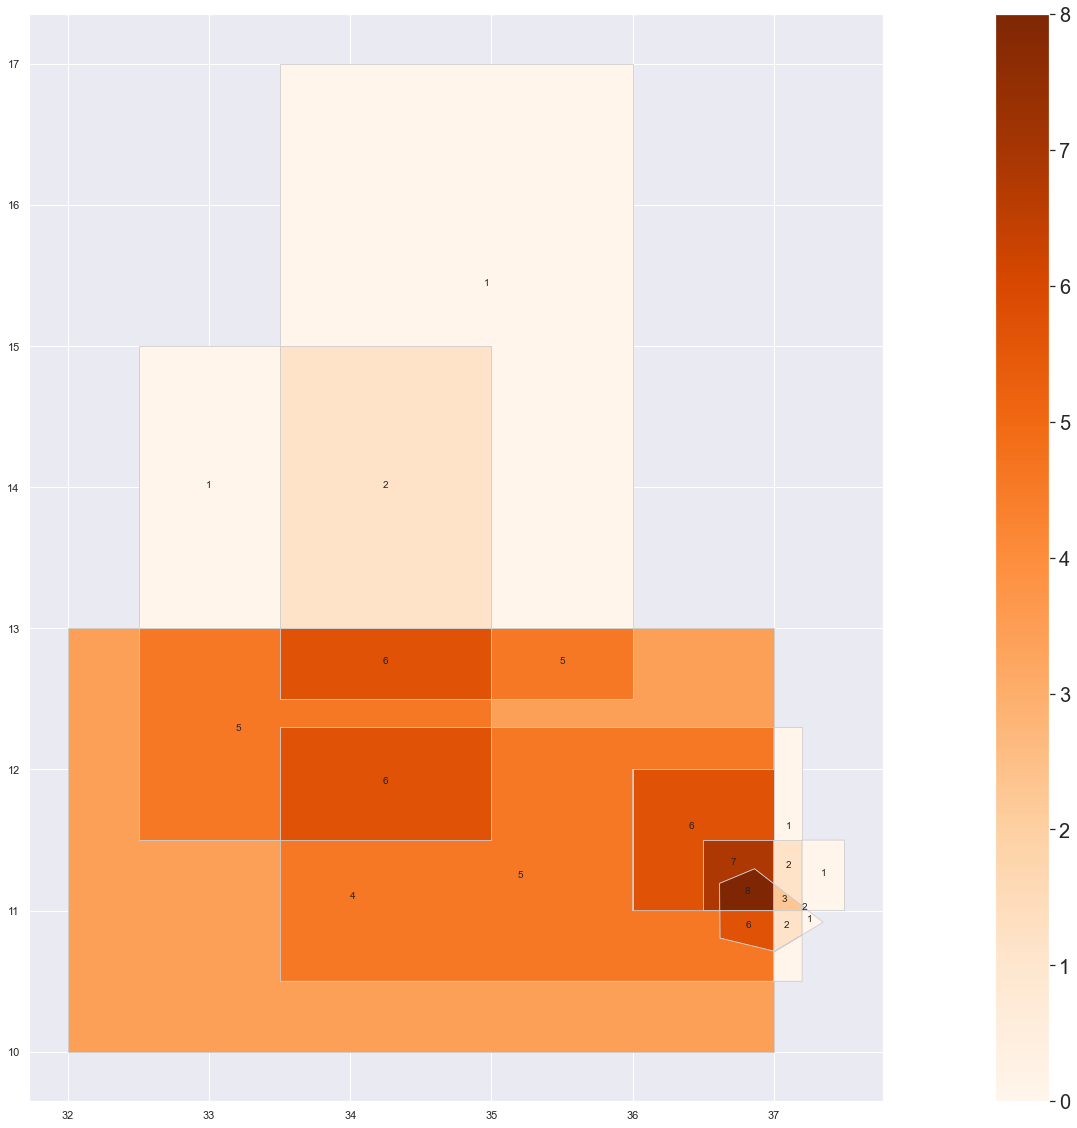

In [192]:
visualization(U, 'geometry', '#polygons')